Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._YTAomJ0XCIRzqKKX.png  
  inflating: /tmp/rockpaperscissors/scissors/TxkHaqZ5Mg3Jfs80.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._TxkHaqZ5Mg3Jfs80.png  
  inflating: /tmp/rockpaperscissors/scissors/Q2F8cfDaghfz8PyX.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._Q2F8cfDaghfz8PyX.png  
  inflating: /tmp/rockpaperscissors/scissors/lSAWzGgHunaNt7jj.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._lSAWzGgHunaNt7jj.png  
  inflating: /tmp/rockpaperscissors/scissors/MfDDFjVkEdWKPi2X.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._MfDDFjVkEdWKPi2X.png  
  inflating: /tmp/rockpaperscissors/scissors/tHvKVZRQUsqNt0g4.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._tHvKVZRQUsqNt0g4.png  
  inflating: /tmp/rockpaperscissors/scissors/EBh8bZgOANio5kQw.png  
  inflating: /tmp/__MACOSX/rockpaperscissors/scissors/._EBh

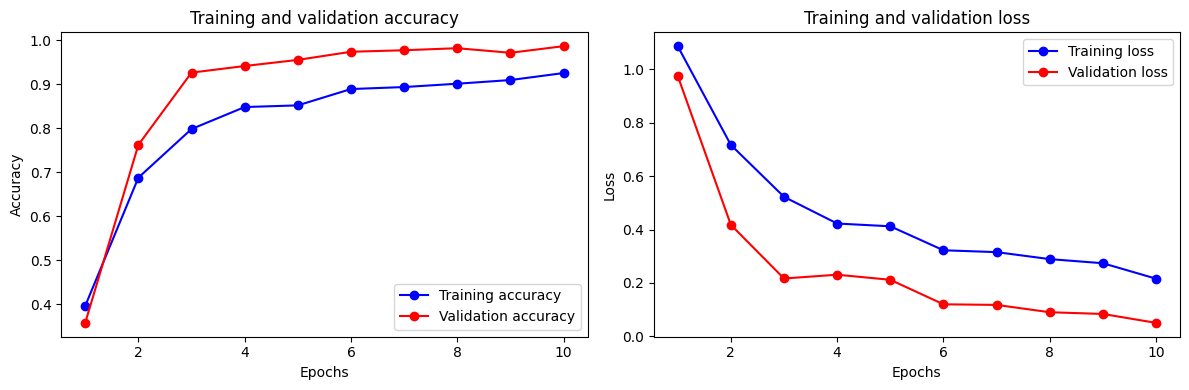

Saving th.jpg to th.jpg
1/1 [==============================] - 0s 200ms/step


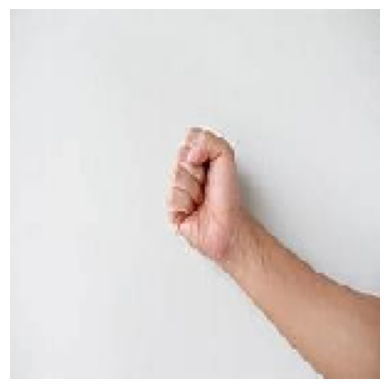

Predicted: rock


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Clone dataset
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

# Ekstrak file zip
!unzip /tmp/rockpaperscissors.zip -d /tmp

# Path dataset
base_dir = '/tmp/rockpaperscissors/'

# Membuat direktori untuk data generator
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Membuat direktori untuk setiap kelas
classes = ['rock', 'paper', 'scissors']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, cls), exist_ok=True)

# Memindahkan gambar ke direktori masing-masing
for cls in classes:
    source_dir = os.path.join(base_dir, 'rps-cv-images', cls)
    for img in os.listdir(source_dir):
        if np.random.rand(1) < 0.6:
            os.replace(os.path.join(source_dir, img), os.path.join(train_dir, cls, img))
        else:
            os.replace(os.path.join(source_dir, img), os.path.join(validation_dir, cls, img))

# Augmentasi gambar
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Pembagian data train dan validation
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

# Membangun model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

# Kompilasi model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Pelatihan model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=[early_stop],
      verbose=1)

# Evaluasi model
_, acc = model.evaluate(validation_generator, verbose=0)
print("Akurasi model: {:.2f}%".format(acc * 100))

# Fungsi untuk memplot loss dan akurasi
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_history setelah pelatihan selesai
plot_history(history)

# Fungsi untuk memprediksi gambar yang diunggah
def predict_image():
    # Mengunggah gambar
    uploaded = files.upload()

    # Memanggil fungsi untuk memprediksi gambar yang diunggah
    for filename in uploaded.keys():
        img = image.load_img(filename, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)

        # Menampilkan gambar
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Mencetak hasil prediksi
        if np.argmax(classes) == 0:
            print('Predicted: rock')
        elif np.argmax(classes) == 1:
            print('Predicted: paper')
        else:
            print('Predicted: scissors')

# Memanggil fungsi untuk memprediksi gambar
predict_image()
